<a href="https://colab.research.google.com/github/afriverat25/ImagesProccesDetectionDacky/blob/main/Centralizacion_de_Imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt


<ipython-input-270-90d5824ff792>:27: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


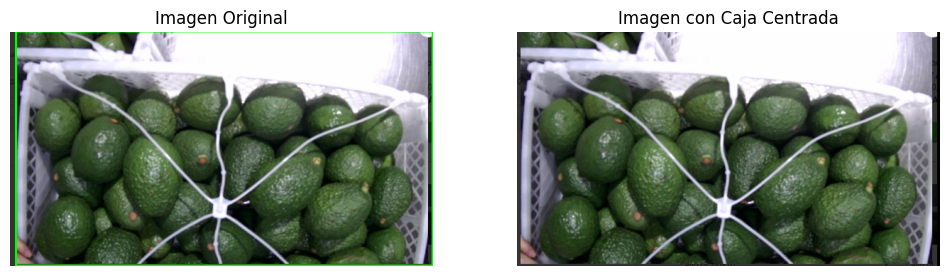

In [ ]:
image = cv2.imread("/content/imagen (1).png")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar desenfoque para reducir el ruido
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detectar bordes usando Canny con umbral ajustado
edges = cv2.Canny(blurred, 10, 100)

# Aplicar transformación morfológica para unir bordes
kernel = np.ones((5, 5), np.uint8)
morphed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Encontrar contornos en la imagen morfológica
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos por tamaño para ignorar frutas y mantener la caja
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

# Obtener el contorno de la caja más grande (si hay varias cajas, podrías adaptarlo)
box_contour = max(large_contours, key=cv2.contourArea)

# Calcular el rectángulo delimitador mínimo para encontrar la orientación de la caja
rect = cv2.minAreaRect(box_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Dibujar el rectángulo en la imagen original
contour_image = image.copy()
cv2.drawContours(contour_image, [box], 0, (0, 255, 0), 2)

# Obtener el bounding box de la caja
x, y, w, h = cv2.boundingRect(box_contour)

# Calcular el centro de la caja y de la imagen
box_center_x, box_center_y = x + w // 2, y + h // 2
image_center_x, image_center_y = image.shape[1] // 2, image.shape[0] // 2

# Calcular el desplazamiento necesario para centrar la caja
dx = image_center_x - box_center_x
dy = image_center_y - box_center_y

# Crear una imagen desplazada del mismo tamaño, rellenando con color de fondo (negro)
translated_image = np.zeros_like(image)
translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])

# Aplicar el desplazamiento
translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))

# Mostrar la imagen original y la imagen centrada
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen con Caja Centrada')
plt.imshow(cv2.cvtColor(translated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

119.66087044946106


<ipython-input-273-e2fc76cf2456>:118: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box1 = np.int0(box1)
<ipython-input-273-e2fc76cf2456>:130: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


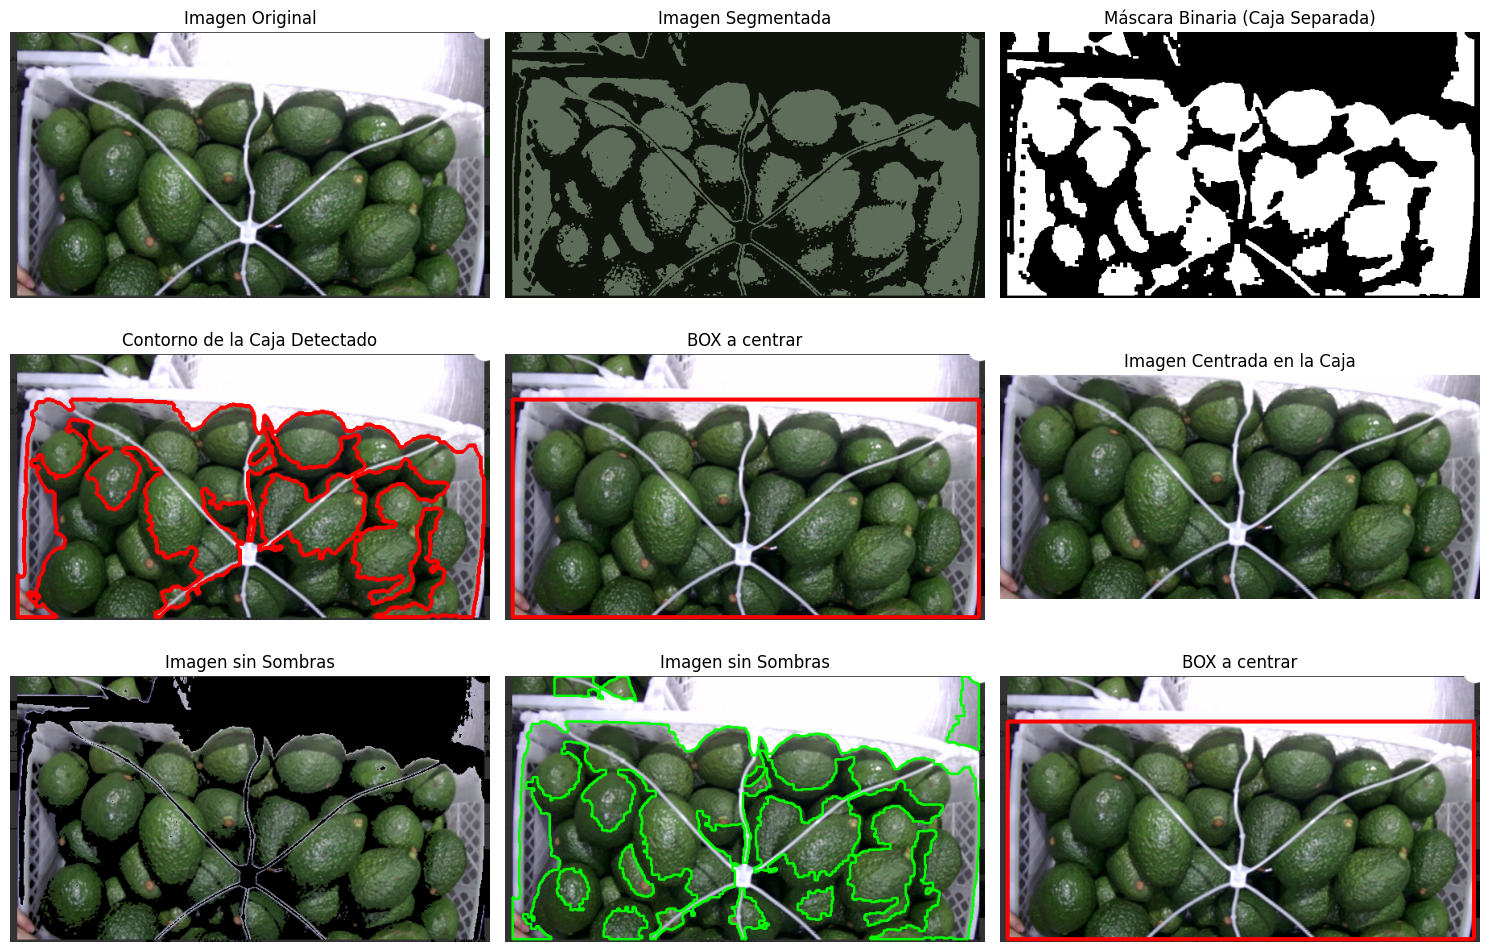

In [ ]:
image = cv2.imread("/content/imagen (1).png")


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convertir la imagen a HSV
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)



# Convertir la imagen a HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Extraer el canal de brillo (V)
brightness_channel = hsv_image[:, :, 2]

# Calcular el brillo promedio
average_brightness = np.mean(brightness_channel)

# Definir un umbral de brillo máximo
max_brightness_threshold = 120  # Ajusta este valor según lo necesario

print(average_brightness)

# Condición para verificar el brillo y decidir si aplicar el filtro
if average_brightness < max_brightness_threshold:
    # Definir rangos para sombras y brillo excesivo
    lower_shadow = np.array([0, 0, 0])
    upper_shadow = np.array([180, 255, 50])

    lower_bright = np.array([0, 0, 200])
    upper_bright = np.array([180, 255, 255])

    # Crear máscaras para sombras y brillo
    shadow_mask = cv2.inRange(image_hsv, lower_shadow, upper_shadow)
    bright_mask = cv2.inRange(image_hsv, lower_bright, upper_bright)

    # Unir las máscaras para obtener una única máscara de sombras y brillo
    combined_mask = cv2.bitwise_or(shadow_mask, bright_mask)

    # Invertir la máscara para mantener solo las áreas de interés
    filtered_mask = cv2.bitwise_not(combined_mask)

    # Aplicar la máscara sin sombras y sin brillo en la imagen original
    image_filtered = cv2.bitwise_and(image_rgb, image_rgb, mask=filtered_mask)

else:
    image_filtered = image_rgb



# Paso 1: Clustering con K-means
Z = image_filtered.reshape((-1, 3))
Z = np.float32(Z)
K = 2 # Puedes ajustar K para obtener una mejor segmentación
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convertir los centros a valores enteros y reorganizar según la etiqueta
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape((image.shape))

# Convertir a escala de grises y aplicar umbral para la máscara binaria
gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(gray_segmented, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Paso 2: Operaciones morfológicas para unificar el contenido dentro de la caja
# Mejorar la segmentación para reducir sombras
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)


# Paso 3: Detección del contorno principal
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Seleccionar el contorno más grande (presumiblemente el de la caja)
contour = max(contours, key=cv2.contourArea)

# Dibujar el contorno y mostrar el área detectada
contour_img = image_rgb.copy()
cv2.drawContours(contour_img, [contour], -1, (255, 0, 0), 3)

# Calcular el bounding box y centrar la imagen
x, y, w, h = cv2.boundingRect(contour)
centered_box_img = image_rgb[y:y+h, x:x+w]

# Paso 3: Detectar el contorno de la caja
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Parámetros de filtrado
aspect_ratio_range = (0.1, 5.0)  # Proporción de aspecto esperada
area_range = (1000, 90000)       # Área esperada de la caja

# Identificar posibles contornos de la caja
filtered_contours = []
for contour in contours:
    # Calcular área y bounding box del contorno
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h if h != 0 else 0

    # Aplicar filtros de área y proporción de aspecto
    if area_range[0] < area < area_range[1] and aspect_ratio_range[0] < aspect_ratio < aspect_ratio_range[1]:
        filtered_contours.append(contour)

# Dibujar los contornos filtrados
image_filtered_contours = image_rgb.copy()
cv2.drawContours(image_filtered_contours, filtered_contours, -1, (0, 255, 0), 2)

contour = max(filtered_contours, key=cv2.contourArea)  # Seleccionar el contorno más grande

# Encontrar el rectángulo rotado mínimo que encierra el contorno
rect1 = cv2.minAreaRect(contour)
box1 = cv2.boxPoints(rect1)
box1 = np.int0(box1)

# Dibujar el bounding box rotado en la imagen original
contour_img_box1 = image_rgb.copy()
cv2.drawContours(contour_img_box1, [box1], 0, (255, 0, 0), 3)  # Dibujar el contorno en rojo


contour = max(contours, key=cv2.contourArea)  # Seleccionar el contorno más grande

# Encontrar el rectángulo rotado mínimo que encierra el contorno
rect = cv2.minAreaRect(contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Dibujar el bounding box rotado en la imagen original
contour_img_box = image_rgb.copy()
cv2.drawContours(contour_img_box, [box], 0, (255, 0, 0), 3)  # Dibujar el contorno en rojo

# Visualización de resultados
plt.figure(figsize=(15, 10))

plt.subplot(3, 3, 1)
plt.title("Imagen Original")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(3, 3, 2)
plt.title("Imagen Segmentada")
plt.imshow(segmented_image)
plt.axis("off")

plt.subplot(3, 3, 3)
plt.title("Máscara Binaria (Caja Separada)")
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.subplot(3, 3, 4)
plt.title("Contorno de la Caja Detectado")
plt.imshow(contour_img)
plt.axis("off")

plt.subplot(3, 3, 5)
plt.title("BOX a centrar")
plt.imshow(contour_img_box)
plt.axis("off")

plt.subplot(3, 3, 6)
plt.title("Imagen Centrada en la Caja")
plt.imshow(centered_box_img)
plt.axis("off")

plt.subplot(3, 3, 7)
plt.title("Imagen sin Sombras")
plt.imshow(image_filtered)
plt.axis("off")


plt.subplot(3, 3, 8)
plt.title("Imagen sin Sombras")
plt.imshow(image_filtered_contours)
plt.axis("off")


plt.subplot(3, 3, 9)
plt.title("BOX a centrar")
plt.imshow(contour_img_box1)
plt.axis("off")


plt.tight_layout()
plt.show()



<ipython-input-274-5d13378b3de4>:7: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


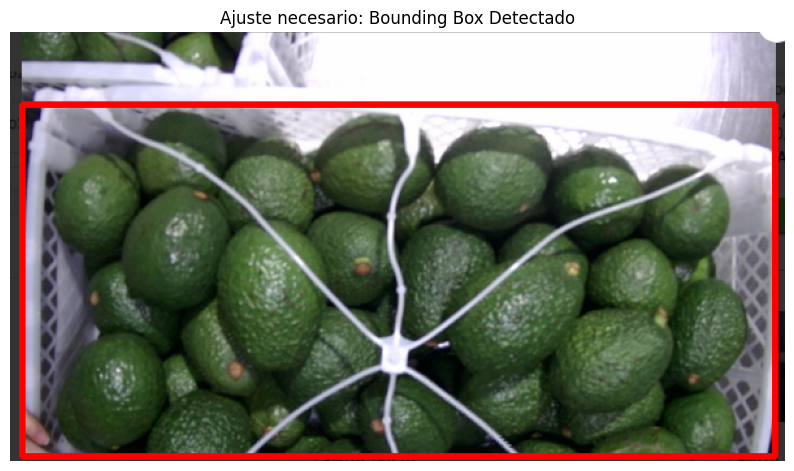

In [ ]:
# Detectar contornos
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Dibujar el contorno en la imagen original
    contour_img = image_rgb.copy()
    cv2.drawContours(contour_img, [box], 0, (255, 0, 0), 3)

    # Verificar si el ajuste es necesario
    original_height, original_width = image.shape[:2]
    _, _, w, h = cv2.boundingRect(contour)
    box_area = w * h
    original_area = original_width * original_height
    adjustment_needed = abs(box_area - original_area) / original_area > 0.05  # Umbral del 5%

    # Mostrar el resultado
    plt.figure(figsize=(10, 7))
    if adjustment_needed:
        plt.title("Ajuste necesario: Bounding Box Detectado")
    else:
        plt.title("Ajuste no es necesario")
    plt.imshow(contour_img)
    plt.axis("off")
    plt.show()
else:
    print("No se detectaron contornos válidos.")

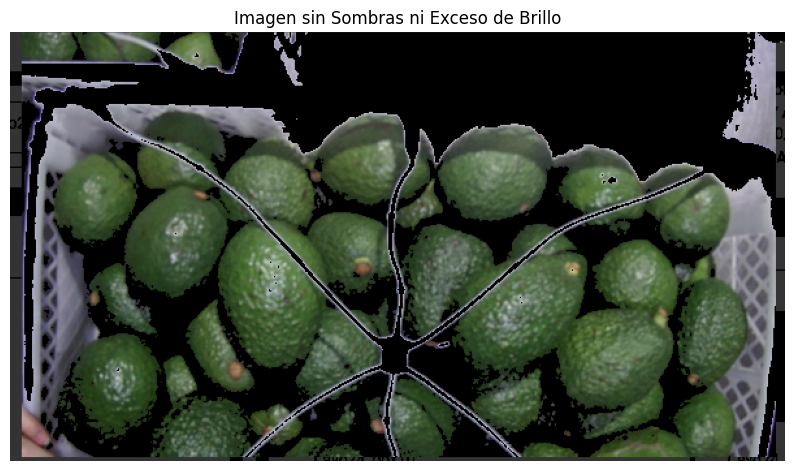

In [ ]:
# Definir rangos para sombras y brillo excesivo
lower_shadow = np.array([0, 0, 0])
upper_shadow = np.array([180, 255, 50])

lower_bright = np.array([0, 0, 200])
upper_bright = np.array([180, 255, 255])

# Crear máscaras para sombras y brillo
shadow_mask = cv2.inRange(image_hsv, lower_shadow, upper_shadow)
bright_mask = cv2.inRange(image_hsv, lower_bright, upper_bright)

# Unir las máscaras para obtener una única máscara de sombras y brillo
combined_mask = cv2.bitwise_or(shadow_mask, bright_mask)

# Invertir la máscara para mantener solo las áreas de interés
filtered_mask = cv2.bitwise_not(combined_mask)

# Aplicar la máscara sin sombras y sin brillo en la imagen original
image_filtered = cv2.bitwise_and(image_rgb, image_rgb, mask=filtered_mask)

# Mostrar el resultado
plt.figure(figsize=(10, 7))
plt.title("Imagen sin Sombras ni Exceso de Brillo")
plt.imshow(image_filtered)
plt.axis("off")
plt.show()